<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/406_reglin_python_tutorial.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>


(reglin_python_notebook)=
# Regressione lineare con Python

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import statistics
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.datasets import get_rdataset
import xarray as xr

In [2]:
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

sns.set_theme(palette="colorblind")

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%config InlineBackend.figure_format = "svg"

Questo tutorial presenta un esercizio di analisi di regressione utilizzando il linguaggio di programmazione Python. In questo esempio analizzeremo i dati di Sahlins sull'economia delle società "primitive". {cite:t}`sahlins2013stone` ha studiato la relazione tra la produzione per lavoratore e la proporzione di consumatori rispetto ai lavoratori nelle famiglie utilizzando i dati raccolti nel villaggio di Mazulu, in Africa centrale. La variabile `acres` rappresenta l'area coltivata da ciascuna famiglia, mentre `consumers` indica il rapporto tra il numero di consumatori e il numero di lavoratori in ogni famiglia. I dati sono contenuti nel DataFrame `Sahlins` del pacchetto R `carData` e possono essere importati in questo Notebook utilizzando la funzione `get_rdataset`.

In [3]:
df = get_rdataset("Sahlins", package="carData", cache=True).data
df.head()

,consumers,acres
0,1.00,1.71
1,1.08,1.52
2,1.15,1.29
3,1.15,3.09
4,1.20,2.21


In [4]:
df.describe().round(2)


,consumers,acres
count,20.00,20.00
mean,1.52,2.16
std,0.35,0.48
min,1.00,1.29
25%,1.27,2.00
50%,1.49,2.19
75%,1.65,2.37
max,2.30,3.09


Creiamo un diagramma a dispersione.

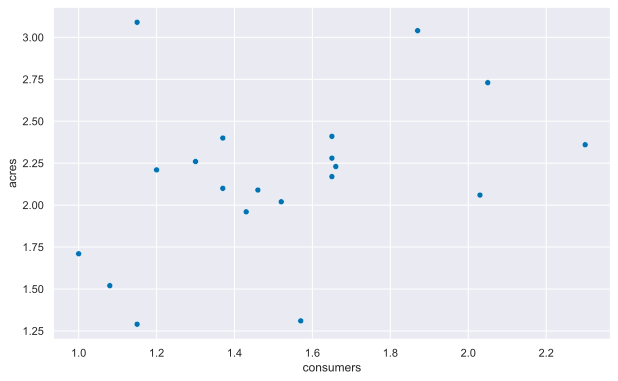

In [5]:
sns.scatterplot(x="consumers", y="acres", data=df);

Aggiungiamo la retta dei minimi quadrati.

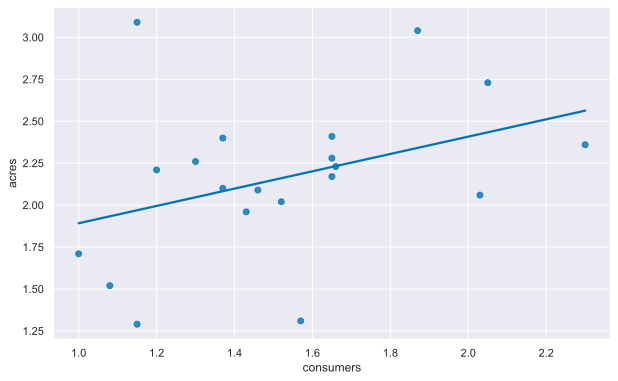

In [6]:
sns.regplot(x="consumers", y="acres", ci=None, data=df);


Troviamo i coefficienti dei minimi quadrati con la funzione `linregress`.

In [7]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df["consumers"], df["acres"])

# Print the coefficients
print("Slope:", slope)
print("Intercept:", intercept)

Slope: 0.5163200600920598
Intercept: 1.3756445484797928


Per replicare il risultato precedente usando le equazioni dei minimi quadrati, iniziamo trovando la matrice di varianza-covarianza tra `acres` e `consumers`. È importante notare che il valore della varianza, a differenza della covarianza e della correlazione, dipende dai gradi di libertà.

In [8]:
np.cov(df["acres"], df["consumers"], ddof=1)


array([[0.22766947, 0.06222526],
       [0.06222526, 0.12051684]])

La covarianza tra `x` e `y` è

In [9]:
s_xy = np.cov(df["acres"], df["consumers"], ddof=1)[0, 1]
print(s_xy)


0.062225263157894735


La varianza di `x` è

In [10]:
v_x = np.cov(df["acres"], df["consumers"], ddof=1)[1, 1]
print(v_x)


0.12051684210526312


Calcoliamo la pendenza della retta di regressione, ovvero il coefficiente $b$.

In [11]:
b = s_xy / v_x
print(b)


0.5163200600920598


Calcoliamo l'intercetta della retta di regressione, ovvero il coefficiente $a$.

In [12]:
a = np.mean(df["acres"]) - b * np.mean(df["consumers"])
print(a)


1.3756445484797928


Usiamo Matplotlib per generare un diagramma a dispersione a cui aggiungiamo la retta di regressione con i coefficienti calcolati in precedenza. Il risultato è identico a quello trovato da Seaborn.

In [13]:
x = df["consumers"]
y = df["acres"]


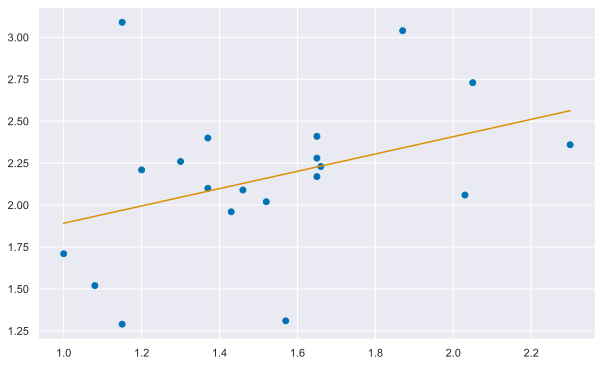

In [14]:
plt.plot(x, y, "o")
plt.plot(x, a + b * x);


## Residui

Consideriamo ora i residui. Iniziamo a calcolare i valori predetti $\hat{y}$.

In [15]:
y_hat = a + b * x
print(y_hat)


0     1.891965
1     1.933270
2     1.969413
3     1.969413
4     1.995229
5     2.046861
6     2.083003
7     2.083003
8     2.113982
9     2.129472
10    2.160451
11    2.186267
12    2.227573
13    2.227573
14    2.227573
15    2.232736
16    2.341163
17    2.423774
18    2.434101
19    2.563181
Name: consumers, dtype: float64


Rappresentiamo i valori $\hat{y}$ con dei quadrati rossi nel grafico che riporta la retta di regressione.

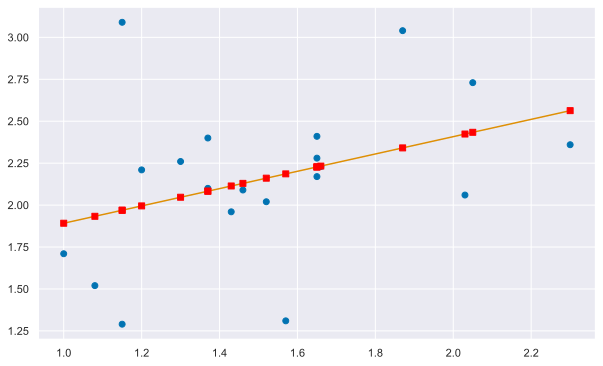

In [16]:
plt.plot(x, y, "o")
plt.plot(x, a + b * x)
plt.plot(x, y_hat, "s", color="red");


Calcoliamo i residui.

In [17]:
e = y - y_hat
print(e)

0    -0.181965
1    -0.413270
2    -0.679413
3     1.120587
4     0.214771
5     0.213139
6     0.316997
7     0.016997
8    -0.153982
9    -0.039472
10   -0.140451
11   -0.876267
12   -0.057573
13    0.052427
14    0.182427
15   -0.002736
16    0.698837
17   -0.363774
18    0.295899
19   -0.203181
dtype: float64


Controlliamo che $\sum_i(e_i) = 0$.

In [18]:
sum(e)


3.1086244689504383e-15

I residui corrispondono ai segmenti verticali che, nel diagramma a dispersione, collegano i punti al valore predetto sulla retta di regressione.

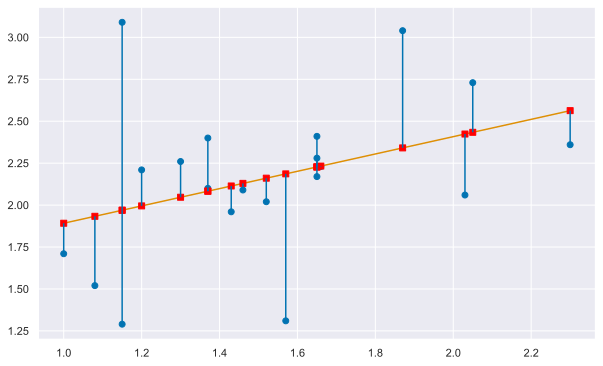

In [19]:
plt.plot(x, y, "o")
plt.plot(x, a + b * x)
plt.plot(x, y_hat, "s", color="red")

plt.vlines(x, y, y - e);


## Correlazione e pendenza della retta di regressione

Se standardizziamo $X$ e $Y$, la pendenza della retta di regressione

$$
b = \frac{S_{x,y}}{Var_{x}}
$$

diventa identica alla correlazione tra le due variabili in quanto, per definizione, la correlazione è la covarianza dei dati standardizzati e, nuovamente per definizione, la varianza di una variabile standardizzata è uguale a 1.

Inoltre, quando i dati sono standardizzati, $a$ = 0, in quanto 

$$
a = \bar{y} - b \cdot \bar{x}.
$$

Per ottenere una dimostrazione numerica, creaimo un diagramma a dispersione con le variabili standardizzate, a cui aggiungeremo la retta di regressione con pendenza uguale a $r$ e intercetta 0.

In [20]:
zx = (x - np.mean(x)) / np.std(x)
zy = (y - np.mean(y)) / np.std(y)


In [21]:
r_xy = np.corrcoef(x, y)[0, 1]
print(r_xy)


0.3756561199682136


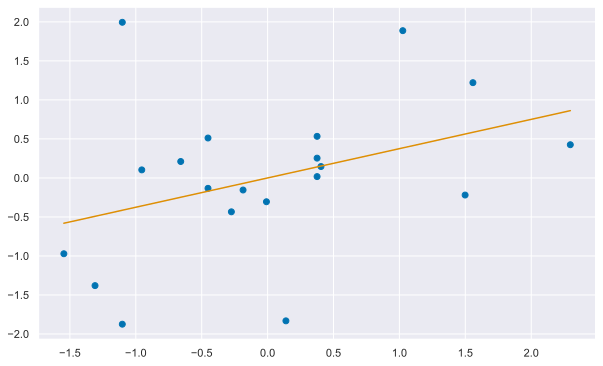

In [22]:
plt.plot(zx, zy, "o")
plt.plot(zx, 0 + r_xy * zx);


Verifichiamo.

In [25]:
df1 = pd.DataFrame({"zx": zx, "zy": zy})

slope, intercept, r_value, p_value, std_err = stats.linregress(df1["zx"], df1["zy"])

# Print the coefficients
print("Slope:", slope)
print("Intercept:", intercept)

Slope: 0.37565611996821363
Intercept: 2.7789083832427757e-16


## Bontà di adattamento

### Scomposizione della devianza

I modelli lineari sono caratterizzati da una scomposizione della devianza totale

$$
DEV_{\text{tot}} = \sum_i{(y_i - \bar{y})^2}
$$

in componenti "spiegate" e "non spiegate".

Calcoliamo la devianza totale.

In [26]:
ss_tot = np.sum((y - np.mean(y)) ** 2)
print(ss_tot)


4.325719999999999


Calcoliamo la devianza spiegata.

In [27]:
ss_reg = np.sum((y_hat - np.mean(y)) ** 2)
print(ss_reg)


0.6104348806456406


Calcoliamo la devianza non spiegata.

In [28]:
ss_err = np.sum((y - y_hat) ** 2)
print(ss_err)


3.7152851193543586


Verifichiamo.

In [29]:
print(ss_reg + ss_err)


4.325719999999999


Calcoliamo l'indice di determinazione.

In [30]:
r2 = ss_reg / ss_tot
print(r2)


0.14111752046957288


Ovvero, usando una formula equivalente

In [32]:
1 - ss_err / ss_tot


0.1411175204695727

Per verificare, eleviamo al quadrato la quantità `r_value` trovata in precedenza. Infatti, nel caso della regressione bivariata, il coefficiente di determinazione è uguale al coefficiente di correlazione di Pearson innalzato al quadrato.

In [33]:
print("Coefficiente di determinazione:", r_value**2)

Coefficiente di determinazione: 0.14111752046957288


L'errore standard della regressione è la deviazione standard dei residui calcolata con l'appropriato numero di gradi di libertà.  Nel caso della regressione bivariata, i gradi di libertà sono $n-2$, dove $n$ è il numero di osservazioni. Si dice che si "perdono" due gradi di libertà a causa del fatto che abbiamo stimato due coefficienti: $a$ e $b$:

$$
s_e = \sqrt{\frac{\sum_i e^2}{n - 2}}.
$$

L'errore standard di regressione ci dà un'indicazione approssimativa della media degli errori residui.

In [35]:
np.sqrt(np.sum(e**2) / (len(df["consumers"]) - 2))


0.45431787203787166

Nel caso attuale, l'errore residuo medio in valore assoluto è

In [38]:
np.mean(np.abs(e))

0.31120830458289295

**Esercizio** Si consideri il seguente set di dati: x = 2, 3, 5, 7; y = 11, 12, 14, 13. Disegnare un grafico a dispersione dei dati. Le variabili sembrano correlate? Calcolare la correlazione tra X e Y per verificarlo.

Definire il modello di regressione con una notazione matematica. Quale segno ci si aspetta per il coefficiente $\beta$? Spiegare la risposta. Stimare l'intercetta e la pendenza della retta di regressione utilizzando le formule dei minimi quadrati. Il segno del coefficiente $\beta$ è consistente con la risposta data in precedenza?

Aggiungere la retta di regressione al grafico a dispersione. Calcolare l'errore standard della regressione. Interpretare in relazione alla rappresentazione grafica dei dati e della retta di regressione.

Scrivere l'equazione del modello di regressione in termini dei coefficienti stimati con il metodo dei minimi quadrati. Calcolare il valore previsto della variabile Y per un valore di X = 4.

Standardizzare i dati. Calcolare la pendenza della retta di regressione calcolata per i dati standardizzati. Confrontare il risultato ottenuto con il coefficiente di correlazione.

Calcolare la devianza totale, la devianza spiegata e la devianza non spiegata. Trovare il coefficiente di determinazione. Interpretare.

Ripetere i calcoli utilizzando una funzione Python e confrontare i risultati ottenuti in precedenza con quelli riportati dal software.

## Inferenza

Nell'approccio frequentista, l'inferenza viene effettuata mediante l'utilizzo di statistiche $t$ e $p$-value, che vengono comunemente riportati nei risultati di software come Statsmodels. Tali test si basano su teoremi matematici specifici, che non saranno affrontati in questo corso. Al contrario, qui ci concentreremo sull'inferenza bayesiana del modello di regressione, che offre una trattazione più semplice e intuitiva di questo argomento.



## Watermark

In [39]:
%load_ext watermark
%watermark -n -u -v -iv 

Last updated: Sat May 06 2023

Python implementation: CPython
Python version       : 3.11.3
IPython version      : 8.13.2

scipy      : 1.10.1
seaborn    : 0.12.2
matplotlib : 3.7.1
arviz      : 0.15.1
numpy      : 1.23.5
statsmodels: 0.14.0
xarray     : 2023.4.2
pandas     : 1.5.3

